# Helpers

In [37]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [2]:
metrics_files = [
    glob.glob('../results/scicite/1 - Instruct Q8/*/metrics/*.csv'),
    glob.glob('../results/scicite/1 - Instruct Q8/zero-shot/metrics/*.csv'),
    glob.glob('../results/scicite/1 - Instruct Q8/one-shot/metrics/*.csv'),
    glob.glob('../results/scicite/1 - Instruct Q8/few-shot/metrics/*.csv'),
    glob.glob('../results/scicite/1 - Instruct Q8/many-shot/metrics/*.csv')
]

In [5]:
def metrics_files_processing(metrics_files, flag):
    data = []
    for m_file in metrics_files:
        # Parse filename to extract metadata
        m_filename = m_file.split('/')[-1]
        parts = m_filename.split('_')

        dataset = parts[2]
        method = parts[3]
        prompt_version = parts[4][2:]  # Remove "SP" prefix
        query_template = parts[5][2:]  # Remove "QT" prefix
        examples_method = parts[6][2:] if "EM" in parts[6] else None  # Handle zero-shot case
        temperature = float(parts[7][1:]) if "T" in parts[7] else float(parts[6][1:]) # Remove "T" prefix

        # Load CSV and add metadata columns
        df = pd.read_csv(m_file)
        df['Dataset'] = dataset
        df['Method'] = method
        df['Prompt_Version'] = prompt_version
        df['Query_Template'] = query_template
        df['Examples_Method'] = examples_method
        df['Temperature'] = temperature
        df['Filename'] = m_filename.split("_metrics_")[-1]

        if flag == 'best':
            # in each dataframe, find the best performing model and set the "best performing" column to 1
            df['Best_Performing'] = 0
            best_f1 = df['F1-Score'].max()
            best_models = df[df['F1-Score'] == best_f1]
            if len(best_models) > 1:
                best_accuracy = best_models['Accuracy'].max()
                df.loc[(df['F1-Score'] == best_f1) & (df['Accuracy'] == best_accuracy), 'Best_Performing'] = 1
            else:
                df.loc[df['F1-Score'] == best_f1, 'Best_Performing'] = 1
        elif flag == 'rank':
            # Sort models by F1-score in descending order
            df = df.sort_values(by=['F1-Score', 'Accuracy'], ascending=[False, False]).reset_index(drop=True)
            # Assign ranking scores (1 for the top model, 1/2 for the second, etc.)
            df['Ranking_Score'] = pd.Series(1 / (df.index + 1)).round(3)
        else:
            raise ValueError(f"Invalid flag: {flag}")

        data.append(df)

    # Concatenate all data
    all_metrics = pd.concat(data, ignore_index=True)
    if flag == 'best':
        all_metrics = all_metrics.sort_values(by=['F1-Score'], ascending=False).reset_index().drop(columns=['index'])
        all_metrics.index += 1
    elif flag == 'rank':
        # Sum the ranking scores for each model across all configurations
        all_metrics = all_metrics.groupby('Model')['Ranking_Score'].sum().reset_index()

        # Sort models by their total ranking score
        all_metrics = all_metrics.sort_values(by='Ranking_Score', ascending=False).reset_index().drop(columns=['index'])
        all_metrics.index += 1
    else:
        raise ValueError(f"Invalid flag: {flag}")

    return all_metrics


def norm_rank(model_scores):
    # Normalize the total ranking scores using Min-Max normalization
    min_score = model_scores['Ranking_Score'].min()
    max_score = model_scores['Ranking_Score'].max()

    model_scores['Normalized_Score'] = (model_scores['Ranking_Score'] - min_score) / (max_score - min_score)

    return model_scores


def plot_rank(model_scores, mode='single', score='rank'):
    if mode == 'single':
        if score == 'rank':
            score_column = [col for col in model_scores.columns if "Ranking_Score" in col]
            score_label = "Rank"
        elif score == 'norm':
            score_column = [col for col in model_scores.columns if "Normalized_Score" in col]
            score_label = "Normalized Rank"

        df_plot = model_scores[["Model"] + score_column].copy()

        df_plot.set_index("Model", inplace=True)
        df_plot.plot(kind='bar', figsize=(10, 6), width=0.8)
        # plt.figure(figsize=(10, 6))
        # plt.barh(model_scores['Model'], score_column, color='skyblue')
        plt.xlabel('Model')
        plt.ylabel(score_label)
        plt.title(f'{score_label}ed Performance by Model')
        # plt.gca().invert_yaxis()
        plt.xticks(rotation=45, ha='right')
        plt.legend().remove()
        plt.tight_layout()
        plt.show()
    elif mode == 'multi':
        if score == 'rank':
            score_columns = [col for col in model_scores.columns if "Ranking_Score" in col]
            score_label = "Rank"
        elif score == 'norm':
            score_columns = [col for col in model_scores.columns if "Normalized_Score" in col]
            score_label = "Normalized Rank"

        # Create a copy of the dataframe with only the relevant columns
        df_plot = model_scores[["Model"] + score_columns].copy()

        # Rename columns to show only the last part after splitting by '_'
        df_plot.rename(columns={col: col.split("_")[-1] for col in score_columns}, inplace=True)
    
        # Set the model names as index
        df_plot.set_index("Model", inplace=True)
        
        # Plot
        df_plot.plot(kind='bar', figsize=(10, 6), width=0.8)
        plt.title(f"{score_label}ed Performance by Model")
        plt.xlabel("Model")
        plt.ylabel(score_label)
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()


def merge_rank_dataframes(dataframes, labels, sort=None):
    merged_df = dataframes[0].copy()
    
    merged_df = merged_df.rename(columns={
        "Ranking_Score": f"Ranking_Score_{labels[0]}",
        "Normalized_Score": f"Normalized_Score_{labels[0]}"
    })

    for i in range(1, len(dataframes)):
        df = dataframes[i].copy()
        df = df.rename(columns={
            "Ranking_Score": f"Ranking_Score_{labels[i]}",
            "Normalized_Score": f"Normalized_Score_{labels[i]}"
        })
        merged_df = merged_df.merge(df, on="Model", how="outer")

    if sort is not None:
        merged_df['Model'] = merged_df['Model'].astype("category")
        merged_df['Model'] = merged_df['Model'].cat.set_categories(sort, ordered=True)

        merged_df = merged_df.sort_values("Model").reset_index(drop=True)
        merged_df.index += 1

    return merged_df


def parameter_distributions(metrics, subset, label):
    topK_counts = metrics[metrics['Top'] == 1].value_counts(subset=[subset])
    topK_percent = metrics[metrics['Top'] == 1].value_counts(subset=[subset], normalize=True)

    df_vc = pd.DataFrame({"count": topK_counts, "%": topK_percent*100}).reset_index()
    df_vc.columns = [label, 'Count', 'Percent']
    df_vc.index += 1

    return df_vc

# Top 50 configurations (sort: F1-score)

In [6]:
metrics_total = metrics_files_processing(metrics_files[0], flag="best")

display(metrics_total.drop(columns=['Filename']).head(50))
metrics_total.drop(columns=['Best_Performing', 'Filename', 'Dataset']).to_csv('scicite_best_performing_models.csv', index=True)


,Model,Precision,Recall,F1-Score,Accuracy,Dataset,Method,Prompt_Version,Query_Template,Examples_Method,Temperature,Best_Performing
1,QWEN2.5_14B,0.7827,0.7891,0.7833,0.8071,scicite,few-shot,3,2,2,0.5,1
2,QWEN2.5_14B,0.7839,0.7865,0.7831,0.8071,scicite,few-shot,3,2,2,1.0,1
3,QWEN2.5_14B,0.7834,0.7865,0.7825,0.8066,scicite,few-shot,3,2,2,0.2,1
4,QWEN2.5_14B,0.7800,0.7940,0.7823,0.8076,scicite,many-shot,3,2,2,0.0,1
5,QWEN2.5_14B,0.7793,0.7929,0.7813,0.8066,scicite,many-shot,3,2,2,0.5,1
6,QWEN2.5_14B,0.7790,0.7922,0.7809,0.8066,scicite,many-shot,3,2,2,0.2,1
7,QWEN2.5_14B,0.7807,0.7857,0.7807,0.8049,scicite,few-shot,3,2,2,0.0,1
8,QWEN2.5_14B,0.7763,0.7895,0.7802,0.8028,scicite,few-shot,2,2,2,0.0,1
9,QWEN2.5_14B,0.7767,0.7929,0.7798,0.8033,scicite,many-shot,3,2,2,1.0,1
10,QWEN2.5_14B,0.7760,0.7851,0.7786,0.8023,scicite,few-shot,2,2,2,1.0,1


# Best Performing Models per Configuration

In [7]:
# display only the best performing models
best_performing = metrics_total[metrics_total['Best_Performing'] == 1]

# Group by 'Model' and 'Method' and count occurrences for each combination
method_counts = best_performing.groupby(['Model', 'Method']).size().unstack(fill_value=0)
method_counts = method_counts[['zero-shot', 'one-shot', 'few-shot', 'many-shot']]

# create a new dataframe with two columns: The model name, and the count of how many times it was the best performing model
best_performing_counts = best_performing['Model'].value_counts().reset_index()
best_performing_counts.columns = ['Model', 'Best Performing Count']
best_performing_counts = best_performing_counts.merge(method_counts, on='Model', how='left')
best_performing_counts.index += 1
display(best_performing_counts)

,Model,Best Performing Count,zero-shot,one-shot,few-shot,many-shot
1,QWEN2.5_14B,114,20,38,27,29
2,MISTRAL_NEMO,20,0,0,11,9
3,GEMMA2-9B,4,0,2,2,0
4,GEMMA2-27B,2,0,0,0,2


### Best Qwen 2.5 14B

In [8]:
best_performing_qwen = best_performing[best_performing['Model'] == 'QWEN2.5_14B'].sort_values(by='F1-Score', ascending=False).reset_index().drop(columns=['Model', 'Dataset', 'Best_Performing', 'index'])
best_performing_qwen.index += 1

# print(best_performing_qwen.value_counts(subset=['Method']))
display(best_performing_qwen)

,Precision,Recall,F1-Score,Accuracy,Method,Prompt_Version,Query_Template,Examples_Method,Temperature,Filename
1,0.7827,0.7891,0.7833,0.8071,few-shot,3,2,2,0.5,scicite_few-shot_SP3_QT2_EM2_T0.5_Q8.csv
2,0.7839,0.7865,0.7831,0.8071,few-shot,3,2,2,1.0,scicite_few-shot_SP3_QT2_EM2_T1.0_Q8.csv
3,0.7834,0.7865,0.7825,0.8066,few-shot,3,2,2,0.2,scicite_few-shot_SP3_QT2_EM2_T0.2_Q8.csv
4,0.7800,0.7940,0.7823,0.8076,many-shot,3,2,2,0.0,scicite_many-shot_SP3_QT2_EM2_T0.0_Q8.csv
5,0.7793,0.7929,0.7813,0.8066,many-shot,3,2,2,0.5,scicite_many-shot_SP3_QT2_EM2_T0.5_Q8.csv
6,0.7790,0.7922,0.7809,0.8066,many-shot,3,2,2,0.2,scicite_many-shot_SP3_QT2_EM2_T0.2_Q8.csv
7,0.7807,0.7857,0.7807,0.8049,few-shot,3,2,2,0.0,scicite_few-shot_SP3_QT2_EM2_T0.0_Q8.csv
8,0.7763,0.7895,0.7802,0.8028,few-shot,2,2,2,0.0,scicite_few-shot_SP2_QT2_EM2_T0.0_Q8.csv
9,0.7767,0.7929,0.7798,0.8033,many-shot,3,2,2,1.0,scicite_many-shot_SP3_QT2_EM2_T1.0_Q8.csv
10,0.7760,0.7851,0.7786,0.8023,few-shot,2,2,2,1.0,scicite_few-shot_SP2_QT2_EM2_T1.0_Q8.csv


### Best MISTRAL NEMO

In [9]:
best_performing_mistral = best_performing[best_performing['Model'] == 'MISTRAL_NEMO'].sort_values(by='F1-Score', ascending=False).reset_index().drop(columns=['Model', 'Dataset', 'Best_Performing', 'index'])
best_performing_mistral.index += 1

display(best_performing_mistral)

,Precision,Recall,F1-Score,Accuracy,Method,Prompt_Version,Query_Template,Examples_Method,Temperature,Filename
1,0.7911,0.7605,0.7739,0.7910,few-shot,1,1,1,0.2,scicite_few-shot_SP1_QT1_EM1_T0.2_Q8.csv
2,0.7820,0.7678,0.7738,0.7958,few-shot,2,2,1,0.0,scicite_few-shot_SP2_QT2_EM1_T0.0_Q8.csv
3,0.7929,0.7590,0.7733,0.7926,few-shot,1,1,1,0.0,scicite_few-shot_SP1_QT1_EM1_T0.0_Q8.csv
4,0.7665,0.7864,0.7731,0.7834,few-shot,1,2,1,0.2,scicite_few-shot_SP1_QT2_EM1_T0.2_Q8.csv
5,0.7680,0.7855,0.7730,0.7845,few-shot,1,2,1,0.0,scicite_few-shot_SP1_QT2_EM1_T0.0_Q8.csv
6,0.7717,0.7616,0.7658,0.7904,few-shot,2,2,1,0.2,scicite_few-shot_SP2_QT2_EM1_T0.2_Q8.csv
7,0.7686,0.7611,0.7643,0.7877,few-shot,2,2,1,0.5,scicite_few-shot_SP2_QT2_EM1_T0.5_Q8.csv
8,0.8112,0.7359,0.7625,0.7910,few-shot,2,1,1,0.0,scicite_few-shot_SP2_QT1_EM1_T0.0_Q8.csv
9,0.8090,0.7329,0.7594,0.7845,few-shot,2,1,1,0.2,scicite_few-shot_SP2_QT1_EM1_T0.2_Q8.csv
10,0.7927,0.7295,0.7534,0.7759,many-shot,2,1,1,0.0,scicite_many-shot_SP2_QT1_EM1_T0.0_Q8.csv


### Best GEMMA 2 - 9B

In [10]:
best_performing_gemma2_9b = best_performing[best_performing['Model'] == 'GEMMA2-9B'].sort_values(by='F1-Score', ascending=False).reset_index().drop(columns=['Model', 'Dataset', 'Best_Performing', 'index'])
best_performing_gemma2_9b.index += 1

display(best_performing_gemma2_9b)

,Precision,Recall,F1-Score,Accuracy,Method,Prompt_Version,Query_Template,Examples_Method,Temperature,Filename
1,0.7397,0.7508,0.7337,0.7593,one-shot,2,1,1,0.5,scicite_one-shot_SP2_QT1_EM1_T0.5_Q8.csv
2,0.7347,0.7489,0.7307,0.7550,one-shot,2,1,1,1.0,scicite_one-shot_SP2_QT1_EM1_T1.0_Q8.csv
3,0.7053,0.7301,0.7070,0.7319,few-shot,2,1,1,1.0,scicite_few-shot_SP2_QT1_EM1_T1.0_Q8.csv
4,0.6947,0.7407,0.7041,0.7222,few-shot,1,1,1,1.0,scicite_few-shot_SP1_QT1_EM1_T1.0_Q8.csv


### Best GEMMA 2 - 27B

In [11]:
best_performing_gemma2_27b = best_performing[best_performing['Model'] == 'GEMMA2-27B'].sort_values(by='F1-Score', ascending=False).reset_index().drop(columns=['Model', 'Dataset', 'Best_Performing', 'index'])
best_performing_gemma2_27b.index += 1

display(best_performing_gemma2_27b)

,Precision,Recall,F1-Score,Accuracy,Method,Prompt_Version,Query_Template,Examples_Method,Temperature,Filename
1,0.7225,0.7479,0.7287,0.7566,many-shot,2,1,2,1.0,scicite_many-shot_SP2_QT1_EM2_T1.0_Q8.csv
2,0.7226,0.7482,0.7284,0.7544,many-shot,2,1,2,0.5,scicite_many-shot_SP2_QT1_EM2_T0.5_Q8.csv


# Ranked Model Performance

### 1. Ranking Models in Each Configuration

For a given experimental configuration $c$ , let:

* $M = m_1, m_2, \dots, m_n$  be the set of models evaluated in configuration $c$.
* $\text{F1}(m_i, c)$ be the F1-score of model $m_i$ in configuration $c$.

Sort the models in $M$ by their F1-scores in descending order:

* $\text{F1}(m_{1}, c) \geq \text{F1}(m_{2}, c) \geq \dots \geq \text{F1}(m_{n}, c)$

where $m_{k}$  is the  $k$-th ranked model in configuration $c$.

### 2. Assigning Scores Based on Rank

For each model $m_{k}$  in configuration $c$, assign a score $S(m_{k}, c)$ based on its rank $k$:

* $S(m_{k}, c) = \frac{1}{k}$

### 3. Aggregating Scores Across Configurations

Let $C$ be the set of all configurations. For each model $m$, calculate the total score $Rank(m)$ by summing its scores across all configurations $c \in C$:

* $Rank(m) = \sum_{c \in C} S(m, c)$

where $S(m, c)$ is the score assigned to model $m$ in configuration $c$. If $m$ does not appear in configuration $c$, then $S(m, c) = 0$.



## All Methods

In [13]:
metrics_rank = metrics_files_processing(metrics_files[0], flag="rank")
display(metrics_rank)

metrics_rank.to_csv('scicite_ranked_models.csv', index=True)

,Model,Ranking_Score
1,QWEN2.5_14B,125.331
2,MISTRAL_NEMO,58.609
3,GEMMA2-27B,48.205
4,GEMMA2-9B,47.786
5,QWEN2,31.951
6,LLAMA3.1,23.585
7,LLAMA3,21.571
8,PHI3.5_MINI,18.833
9,PHI3_MEDIUM,16.866
10,GEMMA2-2B,15.516


### Plot

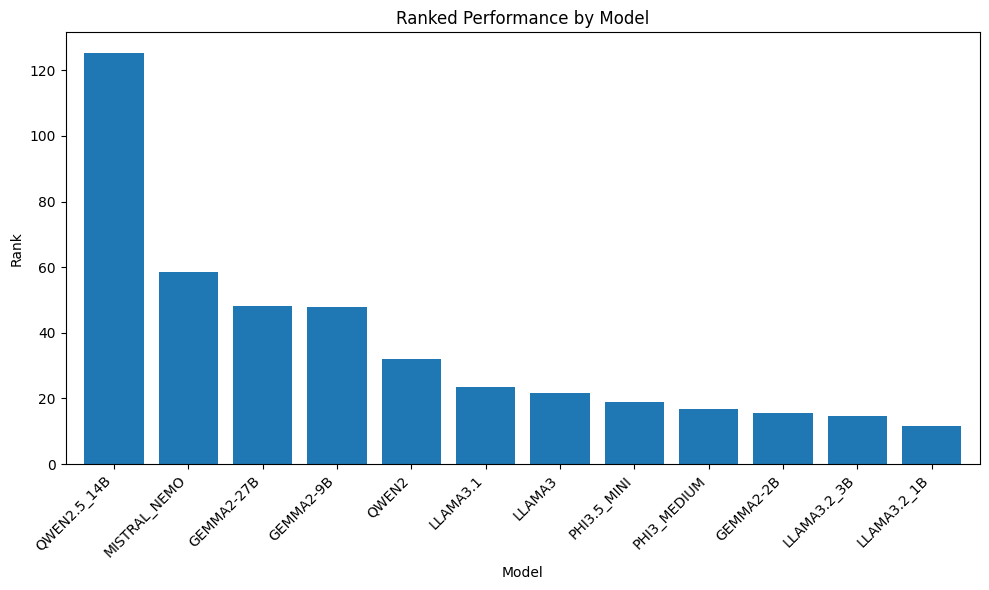

In [14]:
metrics_rank_norm = norm_rank(metrics_rank)
plot_rank(metrics_rank_norm, score='rank')

## Zero-Shot

In [15]:
metrics_rank_zero = metrics_files_processing(metrics_files[1], flag="rank")
display(metrics_rank_zero)

,Model,Ranking_Score
1,QWEN2.5_14B,20.000
2,GEMMA2-27B,10.000
3,GEMMA2-9B,6.245
4,QWEN2,5.165
5,MISTRAL_NEMO,3.604
6,LLAMA3.1,3.492
7,PHI3.5_MINI,2.935
8,LLAMA3,2.734
9,GEMMA2-2B,2.339
10,PHI3_MEDIUM,1.979


### Plot

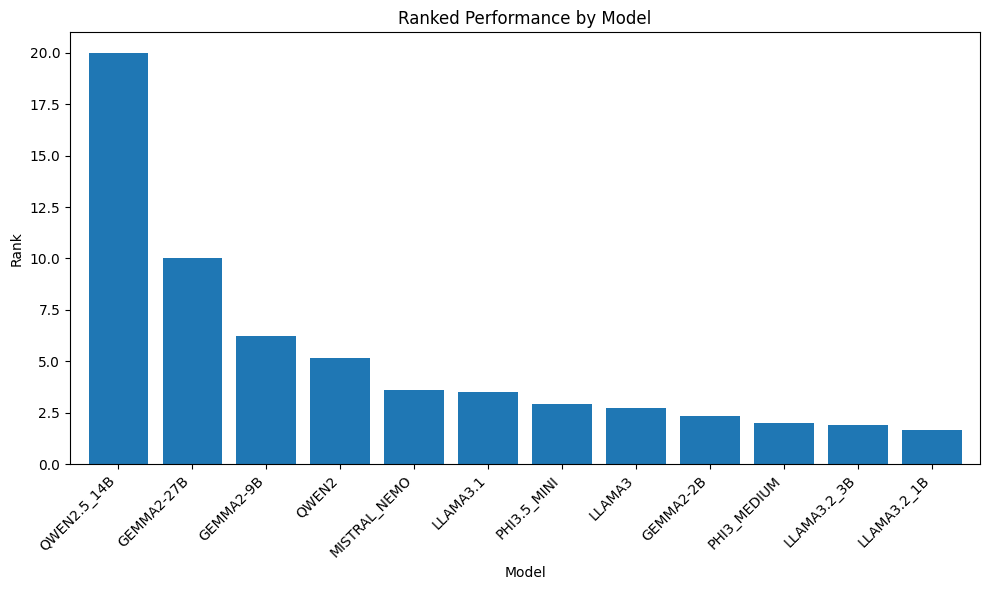

In [16]:
metrics_rank_zero_norm = norm_rank(metrics_rank_zero)
plot_rank(metrics_rank_zero_norm, score='rank')

## One-Shot

In [17]:
metrics_rank_one = metrics_files_processing(metrics_files[2], flag="rank")
display(metrics_rank_one)

,Model,Ranking_Score
1,QWEN2.5_14B,39.000
2,GEMMA2-9B,16.080
3,GEMMA2-27B,13.962
4,MISTRAL_NEMO,12.742
5,QWEN2,8.124
6,LLAMA3,6.124
7,LLAMA3.1,6.032
8,PHI3.5_MINI,5.909
9,PHI3_MEDIUM,4.746
10,GEMMA2-2B,4.044


### Plot

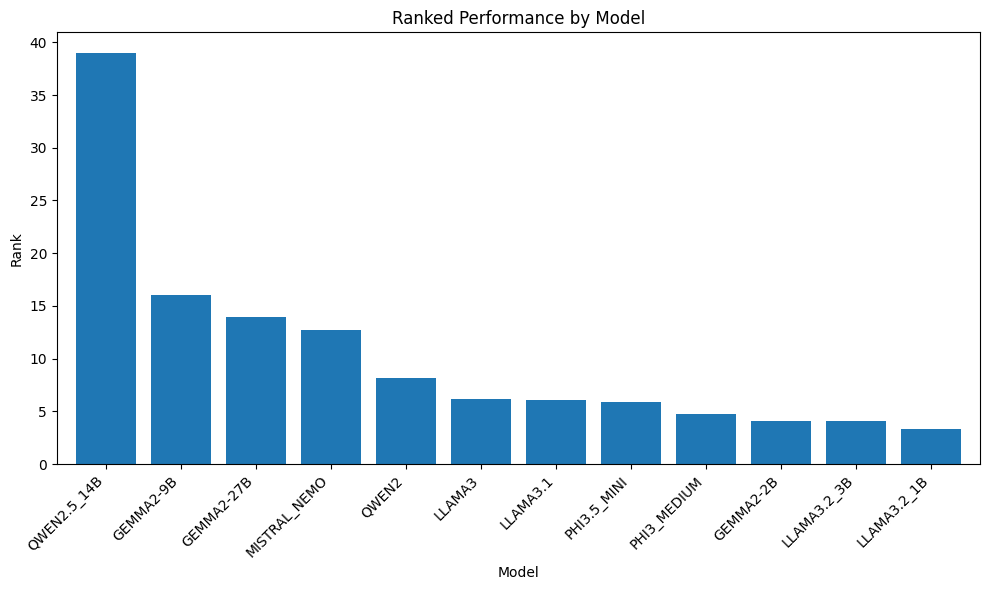

In [18]:
metrics_rank_one_norm = norm_rank(metrics_rank_one)
plot_rank(metrics_rank_one_norm, score='rank')

## Few-Shot

In [19]:
metrics_rank_few = metrics_files_processing(metrics_files[3], flag="rank")
display(metrics_rank_few)

,Model,Ranking_Score
1,QWEN2.5_14B,32.165
2,MISTRAL_NEMO,21.331
3,GEMMA2-9B,14.472
4,GEMMA2-27B,11.144
5,QWEN2,9.709
6,LLAMA3.1,7.445
7,LLAMA3,5.935
8,PHI3.5_MINI,5.062
9,PHI3_MEDIUM,4.757
10,GEMMA2-2B,4.465


### Plot

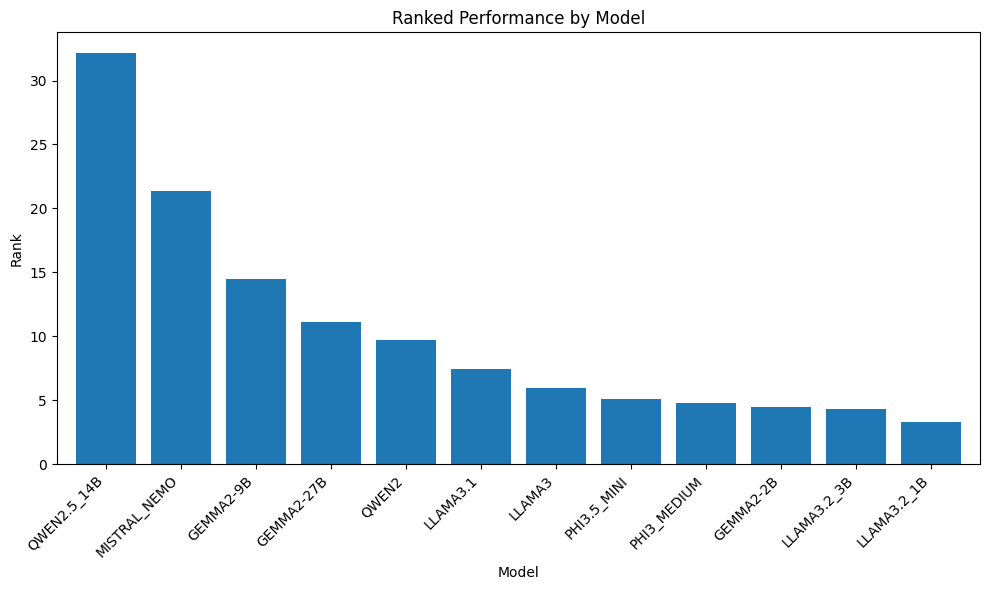

In [20]:
metrics_rank_few_norm = norm_rank(metrics_rank_few)
plot_rank(metrics_rank_few_norm, score='rank')

## Many-Shot

In [21]:
metrics_rank_many = metrics_files_processing(metrics_files[4], flag="rank")
display(metrics_rank_many)

,Model,Ranking_Score
1,QWEN2.5_14B,34.166
2,MISTRAL_NEMO,20.932
3,GEMMA2-27B,13.099
4,GEMMA2-9B,10.989
5,QWEN2,8.953
6,LLAMA3,6.778
7,LLAMA3.1,6.616
8,PHI3_MEDIUM,5.384
9,PHI3.5_MINI,4.927
10,GEMMA2-2B,4.668


### Plot

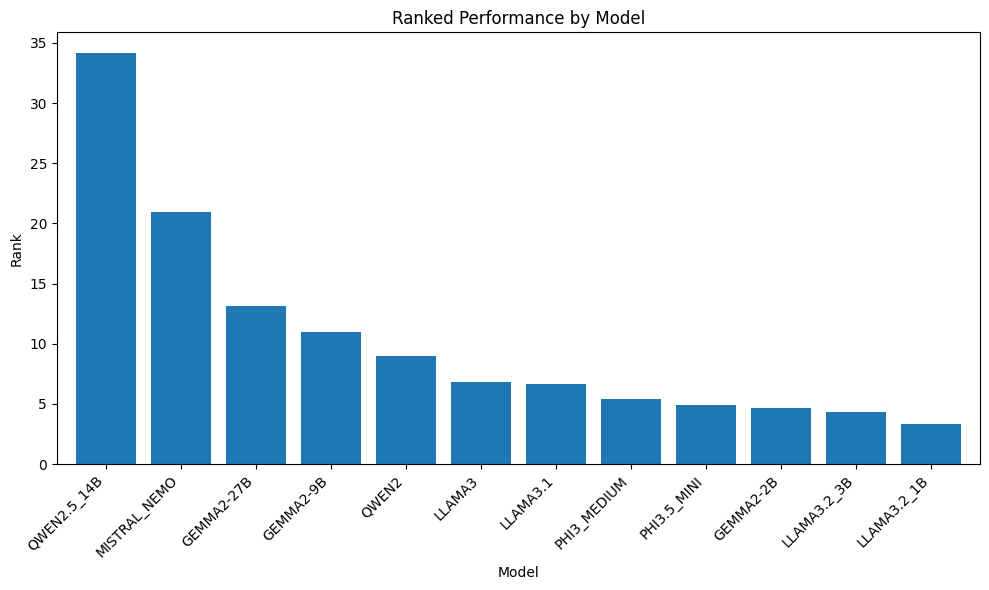

In [22]:
metrics_rank_many_norm = norm_rank(metrics_rank_many)
plot_rank(metrics_rank_many_norm, score='rank')

## Overall Shot Method Comparison

### Plot Methods Grouped

In [23]:
metrics_rank_dataframes_methods_only = [metrics_rank_zero_norm, metrics_rank_one_norm, metrics_rank_few_norm, metrics_rank_many_norm]
df_labels=['Zero-Shot', 'One-Shot', 'Few-Shot', 'Many-Shot']
model_sort = metrics_rank['Model'].tolist()

metrics_rank_dataframes_methods_only = merge_rank_dataframes(dataframes=metrics_rank_dataframes_methods_only, labels=df_labels, sort=model_sort)

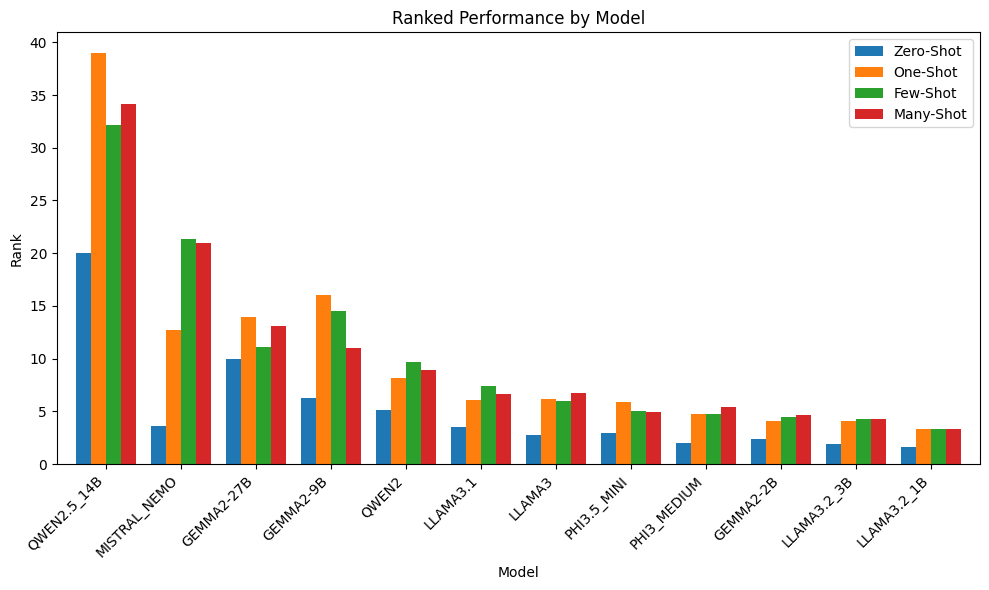

In [24]:
# plot_rank(metrics_rank_dataframes_methods_only, mode='multi', score='norm')
plot_rank(metrics_rank_dataframes_methods_only, mode='multi', score='rank')

### Plot Methods Grouped + Total

In [25]:
metrics_rank_dataframes = [metrics_rank_norm, metrics_rank_zero_norm, metrics_rank_one_norm, metrics_rank_few_norm, metrics_rank_many_norm]
df_labels=['All Methods', 'Zero-Shot', 'One-Shot', 'Few-Shot', 'Many-Shot']
metrics_rank_all = merge_rank_dataframes(dataframes=metrics_rank_dataframes, labels=df_labels)

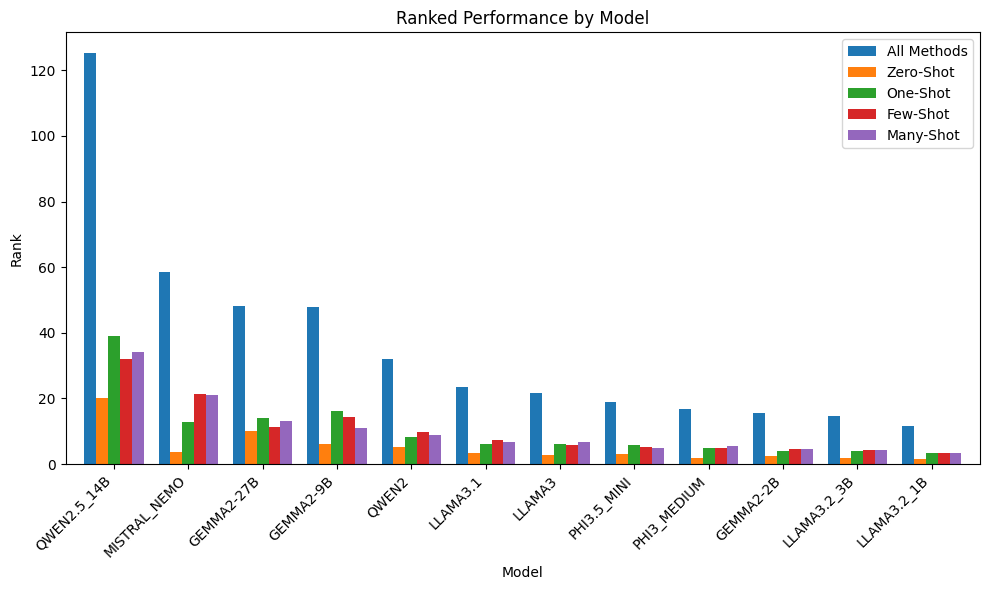

In [26]:
# plot_rank(metrics_rank_all, mode='multi', score='norm')
plot_rank(metrics_rank_all, mode='multi', score='rank')

## Merged Plot of Datasets

In [27]:
scicite_ranked = pd.read_csv('scicite_ranked_models.csv')
acl_arc_ranked = pd.read_csv('acl-arc_ranked_models.csv')

scicite_ranked_norm = norm_rank(scicite_ranked)
acl_arc_ranked_norm = norm_rank(acl_arc_ranked)

merged_ranked_datasets = merge_rank_dataframes([scicite_ranked_norm, acl_arc_ranked_norm], ["scicite", "acl-arc"])

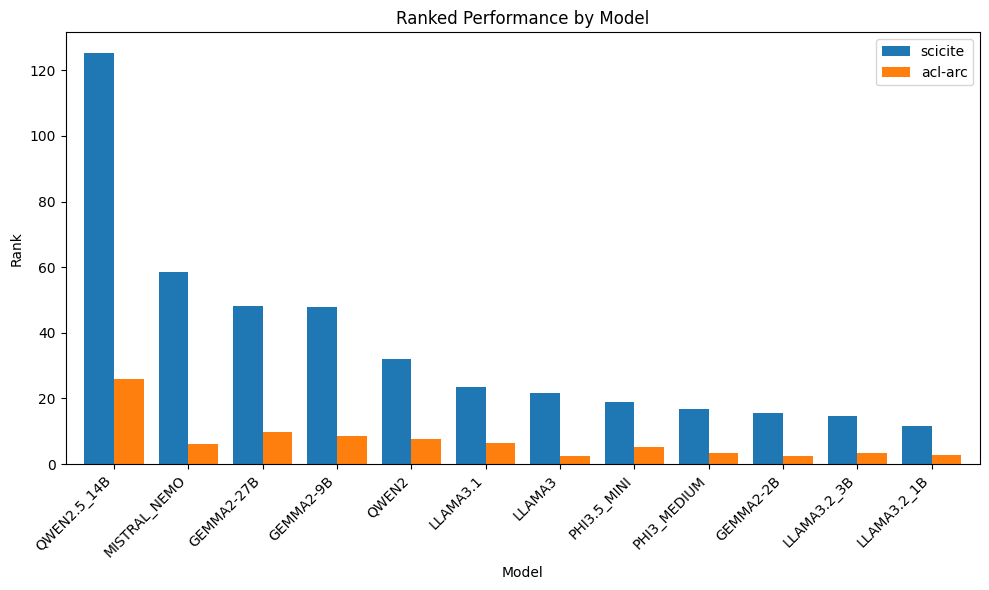

In [28]:
plot_rank(merged_ranked_datasets, mode='multi', score='rank')

# Generalized Parameter Analysis

In [30]:
if 'Top' in metrics_total.columns:
    metrics_total = metrics_total.drop(columns=['Top'])

# top_k = 50
# metrics_total['Top'] = metrics_total.index <= top_k  # Binary indicator for top configs

# top_quantile = 0.1
top_quantile = 0.05
metrics_total['Top'] = metrics_total['F1-Score'] >= metrics_total['F1-Score'].quantile(1 - top_quantile)

## 1. Prompting Method

Check the prompting method distribution of the top-K configurations to identify if there is an optimal one.

In [31]:
method_vc = parameter_distributions(metrics_total, 'Method', 'Method')
display(method_vc)

,Method,Count,Percent
1,few-shot,40,47.058824
2,many-shot,30,35.294118
3,one-shot,14,16.470588
4,zero-shot,1,1.176471


## 2. Temperature

Check the temperature distribution of the top-K configurations to identify if there is an optimal one.

In [32]:
temp_vc = parameter_distributions(metrics_total, 'Temperature', 'Temperature')
display(temp_vc)

,Temperature,Count,Percent
1,0.2,26,30.588235
2,0.0,25,29.411765
3,0.5,17,20.000000
4,1.0,17,20.000000


## 3. System Prompt

Check the System Prompt distribution of the top-K configurations to identify if there is an optimal one.

In [33]:
sp_vc = parameter_distributions(metrics_total, 'Prompt_Version', 'System Prompt')
display(sp_vc)

,System Prompt,Count,Percent
1,3,29,34.117647
2,1,28,32.941176
3,2,28,32.941176


## 4. Query Template

Check the Query Template distribution of the top-K configurations to identify if there is an optimal one.

In [34]:
qt_vc = parameter_distributions(metrics_total, 'Query_Template', 'Query Template')
display(qt_vc)

,Query Template,Count,Percent
1,2,80,94.117647
2,1,5,5.882353


## 5. Examples Method

Check the Examples Method distribution of the top-K configurations to identify if there is an optimal one.

In [35]:
em_vc = parameter_distributions(metrics_total, 'Examples_Method', 'Examples Method')
display(em_vc)

,Examples Method,Count,Percent
1,2,43,51.190476
2,1,41,48.809524


## 5. Chi-Square Test of Independence

In [36]:
for col in ['Method', 'Temperature', 'Prompt_Version', 'Query_Template', 'Examples_Method']:
    contingency = pd.crosstab(metrics_total[col], metrics_total['Top'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"Chi-Square test for {col}: chi2={chi2}, p={p}")

Chi-Square test for Method: chi2=27.484713258344094, p=4.658791875137683e-06
Chi-Square test for Temperature: chi2=3.6059745528305367, p=0.3072754337366064
Chi-Square test for Prompt_Version: chi2=11.15249861700166, p=0.0037867418170553207
Chi-Square test for Query_Template: chi2=41.93804167434999, p=9.42117878727798e-11
Chi-Square test for Examples_Method: chi2=0.012642225031605562, p=0.9104764045744151
